# 라이브러리 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import os
import random

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# test image 특징 추출

In [3]:
image = cv2.imread('/content/20130503000023_0.jpeg', cv2.IMREAD_COLOR) #예시 이미지 불러오기

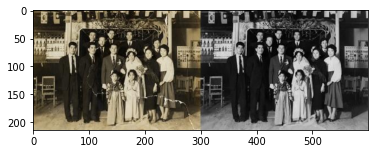

In [4]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [5]:
image1 = image[:, :300, :]
image2 = image[:, 300:, :] #이미지 분리. 가로의 사이즈가 600이다.

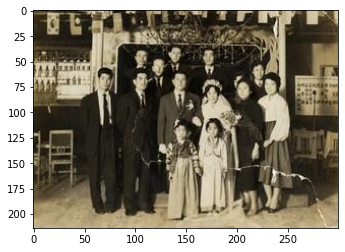

In [6]:
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB));

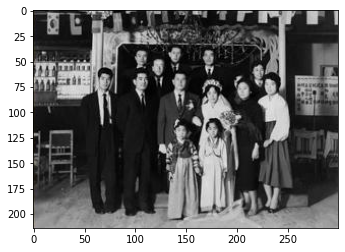

In [7]:
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB));

흑백이미지인 image2에서 image1을 뺀 상태  
이를 통해 원본이미지에서 어떤 값이 추가로 들어갔는지 알 수 있다.

In [8]:
ex_image = image2 - image1

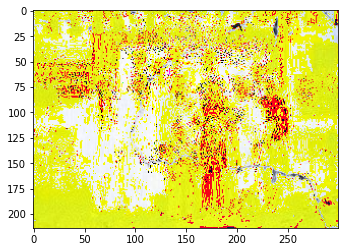

In [9]:
"""
노랑색이 주로 들어갔다는 것을 확인할 수 있다.
"""
plt.imshow(cv2.cvtColor(ex_image, cv2.COLOR_BGR2RGB));

# RGB값 비교 그래프
바로 아래의 그래프가 흑백 원본이며, 그 밑의 이미지가 빛 바랜 이미지이다.  
보시다시피분산이 더 크며, 같은 Blue 값에 비해 Red값과 Green 값이 더 높다.  
그래프를 보면, blue는 Green, red와 정의 관계를 관계를 가지고 있다.

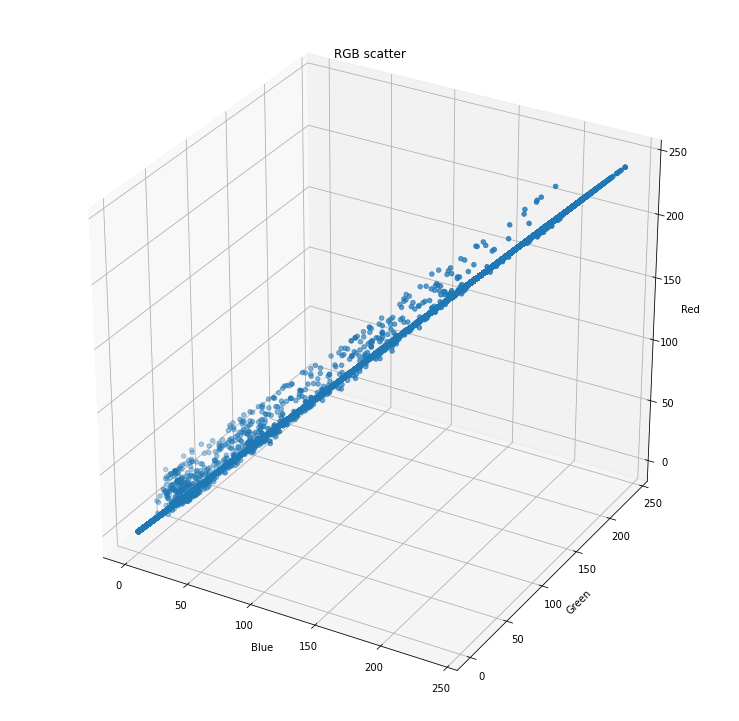

In [10]:
from matplotlib import projections
fig = plt.figure(figsize=(13, 13))
ax = fig.gca(projection = '3d')

X = image2[:, :, 0]
Y = image2[:, :, 1]
Z = image2[:, :, 2]

ax.scatter(X, Y, Z)

ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")
plt.title("RGB scatter")
plt.show()

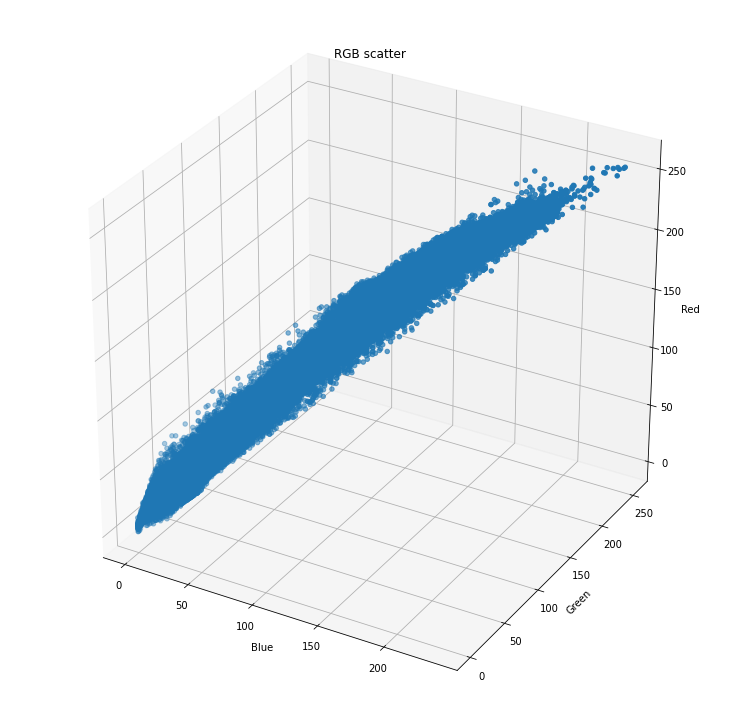

In [11]:
from matplotlib import projections
fig = plt.figure(figsize=(13, 13))
ax = fig.gca(projection = '3d')

X = image1[:, :, 0]
Y = image1[:, :, 1]
Z = image1[:, :, 2]

ax.scatter(X, Y, Z)

ax.set_xlabel("Blue")
ax.set_ylabel("Green")
ax.set_zlabel("Red")
plt.title("RGB scatter")
plt.show()

# RGB 중 B 값에 따른 Red값과 Green값을 추출하여 dictionary 형태로 저장
2가지의 dict을 만들어 각각 green값과 red값을 리스트 형태로 저장  
각각의 dict의 key 값은 blue값임  
즉, blue 값에 대응하는 R, G 값을 추출하는 과정  

In [12]:
"""
blue 값에 대응하는 R, G 값을 추출하여,
각각의 key에 대한 리스트 값으로 저장
"""

test_dict_g = {}
test_dict_r = {}
for i in range(image1.shape[0]):
  for j in range(image1.shape[1]):
    if image1[i][j][0] not in test_dict_g:
      test_dict_g[image1[i][j][0]] = [image1[i][j][1]]
    else:
      test_dict_g[image1[i][j][0]].append(image1[i][j][1])
    
    if image1[i][j][0] not in test_dict_r:
      test_dict_r[image1[i][j][0]] = [image1[i][j][1]]
    else:
      test_dict_r[image1[i][j][0]].append(image1[i][j][1])

In [13]:
np.var(test_dict_g[0])

45.5918248531938

# 추출된 dict 값에서 각각의 key값에 대한 평균 값과 분산 값을 구하여 새로운 dict에 저장함

In [14]:
test_dict_g_mean_var = {}
test_dict_r_mean_var = {}
for key in test_dict_g.keys():
  mean = np.mean(test_dict_g[key])
  var = np.var(test_dict_g[key])
  test_dict_g_mean_var[key] = [mean, var]

for key in test_dict_r.keys():
  mean = np.mean(test_dict_r[key])
  var = np.var(test_dict_r[key])
  test_dict_r_mean_var[key] = [mean, var]

# 빛 바랜 이미지 생성

In [15]:
def make_faded(image, test_dict_g_mean_var, test_dict_r_mean_var, green_alpha, red_alpha):
  temp_image = copy.deepcopy(image)
  for i in temp_image:
    for j in i:
      if j[0] in test_dict_g_mean_var:
        j[1] = np.random.normal(loc=test_dict_g_mean_var[j[0]][0]*green_alpha, scale=np.sqrt(test_dict_g_mean_var[j[0]][1]))
      if j[0] in test_dict_r_mean_var:
        j[2] = np.random.normal(loc=test_dict_r_mean_var[j[0]][0]*red_alpha, scale=np.sqrt(test_dict_r_mean_var[j[0]][1]))
  
  return temp_image

In [16]:
test_image2 = make_faded(image2, test_dict_g_mean_var, test_dict_r_mean_var, 1.0, 1.0)

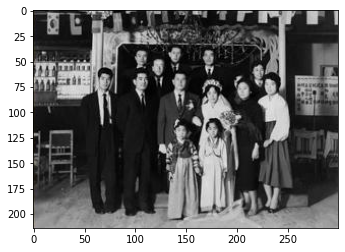

In [17]:
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB));

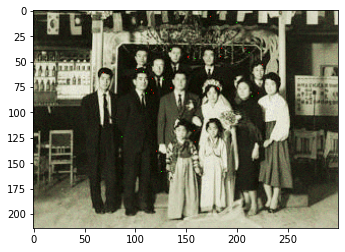

In [18]:
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB));

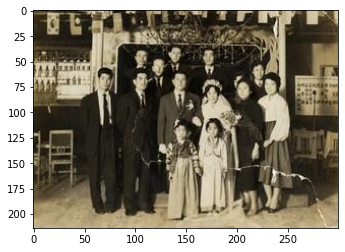

In [19]:
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB));

# Model
AutoEncoder 방식을 사용

In [20]:
class ResiAutoEncoder(tf.keras.Model):
  def __init__(self, hid_dim, **kwargs):
    super().__init__(**kwargs)
    self.hid_dim = hid_dim
    self.encoder = tf.keras.Sequential([
                                        
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.MaxPooling2D(pool_size=2),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.MaxPooling2D(pool_size=2),
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu)
    ])
    self.decoder = tf.keras.Sequential([
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*4, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.UpSampling2D(size=2),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim*2, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.UpSampling2D(size=2),
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                        tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu)
    ])

  def call(self, input):
    encoder_output = self.encoder(input)
    decoder_ouptut = self.decoder(encoder_output)
    return decoder_ouptut + input #residual connection

In [21]:
class CustomModel(tf.keras.Model):
  def __init__(self, hid_dim, **kwargs):
    super().__init__(**kwargs)
    self.hid_dim = hid_dim
    self.feature_extraction_layer = tf.keras.Sequential([
                                                         tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                         tf.keras.layers.Conv2D(self.hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                         tf.keras.layers.Conv2D(self.hid_dim*3, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                         tf.keras.layers.Conv2D(self.hid_dim*3, kernel_size=1, padding='same', activation=tf.nn.leaky_relu),
    ])
    self.remove_noise_layer = ResiAutoEncoder(self.hid_dim, **kwargs) #noise_layer
    self.remove_faded_layer = ResiAutoEncoder(self.hid_dim, **kwargs) #faded_layer
    self.convert_color_layer = ResiAutoEncoder(self.hid_dim, **kwargs) #gray_layer

    self.last_conv_layer = tf.keras.Sequential([
                                                tf.keras.layers.Conv2D(hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                tf.keras.layers.Conv2D(hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                tf.keras.layers.Conv2D(hid_dim, kernel_size=3, padding='same', activation=tf.nn.leaky_relu),
                                                tf.keras.layers.Conv2D(3, kernel_size=1)
    ])

  def call(self, input):
    feature_extraction_data = self.feature_extraction_layer(input)
    noise, faded, color = feature_extraction_data[:, :, :, :self.hid_dim], feature_extraction_data[:, :, :, self.hid_dim:self.hid_dim*2], feature_extraction_data[:, :, :, self.hid_dim*2:self.hid_dim*3] #3가지로 분리
    noise_output = self.remove_noise_layer(noise)
    faded_output = self.remove_faded_layer(faded)
    color_output = self.convert_color_layer(color)
    output = noise_output + faded_output + color_output
    output = self.last_conv_layer(output)
    return output

# 데이터 불러오기
Kaggle에서 데이터 불러오기  
dataset 주소: https://www.kaggle.com/datasets/arnaud58/landscape-pictures

In [22]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alzoqm","key":"fc26ffa65cb1e966aad1e8bce5095669"}'}

In [24]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [25]:
!kaggle datasets download -d arnaud58/landscape-pictures

 97% 604M/620M [00:04<00:00, 159MB/s]
100% 620M/620M [00:04<00:00, 134MB/s]


In [ ]:
!unzip /content/landscape-pictures.zip -d /content/dataset

In [28]:
data_path = '/content/dataset'
listdir = os.listdir(data_path)
len(listdir) // 8

539

# 데이터 생성 절차
1. 이미지를 컬러와 흑백 두가지 버전으로 불러오기  
2. 흑백 이미지에 대해서 노이즈를 더한 후 흑백 이미지와 노이즈 이미지를 temp폴더에 일시 저장  
3. 저장한 흑백 이미지와 노이즈 이미지를 다시 컬러 이미지 형태로 불러와서 빛 바랜 효과 추가  
4. 위의 경우를 batch_size만큼 반복하여 5가지의 버전의 이미지를 생성하여 반환

In [29]:
def make_dataset(steps, listdir, dataset_address, batch_size, noise_value, green_alpha, red_alpha):
  color_image_list = []
  gray_image_list = []
  noise_image_list = []
  faded_image_list = []
  noise_faded_image_list = []
  for step_data in range(steps*batch_size, (steps+1)*(batch_size)):
    color_image = cv2.imread(dataset_address + '/' + listdir[step_data], cv2.IMREAD_COLOR)
    color_image = color_image[:256, :256]
    gray_image = cv2.imread(dataset_address + '/' + listdir[step_data], cv2.IMREAD_GRAYSCALE)
    gray_image = gray_image[:256, :256]
    color_image = cv2.resize(color_image, dsize=(64, 64))
    gray_image = cv2.resize(gray_image, dsize=(64, 64))

    noise_image = gray_image + np.random.normal(size=gray_image.shape, scale=noise_value)

    cv2.imwrite('/content/temp/gray_image.jpeg', gray_image) #임시 저장
    cv2.imwrite('/content/temp/noise_image.jpeg', noise_image) #임시 저장

    gray_image = cv2.imread('/content/temp/gray_image.jpeg', cv2.IMREAD_COLOR)
    noise_image = cv2.imread('/content/temp/noise_image.jpeg', cv2.IMREAD_COLOR)

    faded_image = make_faded(gray_image, test_dict_g_mean_var, test_dict_r_mean_var, green_alpha, red_alpha)
    noise_faded_image = make_faded(noise_image, test_dict_g_mean_var, test_dict_r_mean_var, green_alpha, red_alpha)

    color_image_list.append(color_image)
    gray_image_list.append(gray_image)
    noise_image_list.append(noise_image)
    faded_image_list.append(faded_image)
    noise_faded_image_list.append(noise_faded_image)

    os.remove('/content/temp/gray_image.jpeg') #임시 저장 파일 삭제
    os.remove('/content/temp/noise_image.jpeg') #임시 저장 파일 삭제

  return np.array(color_image_list),  np.array(gray_image_list),  np.array(noise_image_list),  np.array(faded_image_list),  np.array(noise_faded_image_list)

In [30]:
"""
데이터를 불러올때 임시로 저장할 파일 생성
"""

if os.path.isdir('/content/temp') == False: #폴더 생성 유뮤 확인
  os.mkdir('/content/temp')

#TPU 환경에서 학습 진행

In [31]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.14.0.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.0.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [32]:
#하이퍼 파라미터
HID_DIM = 64
LR = 2e-5
EPOCHS = 30
BATCH_SIZE_PER_REPLICA = 1
BATCH_SIZE = (BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync) # 값은 8 * BATCH_SIZE_PER_REPLICA

In [33]:
with strategy.scope():
  model = CustomModel(HID_DIM)
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
  training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
  save_weight_path='/content/drive/MyDrive/ColabNotebooks/project/CV_Project/model_weight2.h5'
  
  x = tf.random.normal(shape=(1, 512, 512, 3), dtype=tf.float32)
  output = model(x)
  model.summary()
  model.load_weights(save_weight_path)

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 512, 512, 192)        186560    
                                                                 
 resi_auto_encoder (ResiAuto  multiple                 4463232   
 Encoder)                                                        
                                                                 
 resi_auto_encoder_1 (ResiAu  multiple                 4463232   
 toEncoder)                                                      
                                                                 
 resi_auto_encoder_2 (ResiAu  multiple                 4463232   
 toEncoder)                                                      
                                                                 
 sequential_7 (Sequential)   (1, 512, 512, 3)          110979    
                                                      

In [ ]:
def train_step(inputs):
  input_image, label_image = inputs
  input_image = tf.cast(input_image, dtype=tf.float32)
  #label_image = tf.cast(label_image, dtype=tf.float32)
  with tf.GradientTape() as tape:
    logits = model(input_image, training=True)
    loss = tf.keras.losses.MSE(label_image, logits)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  del input_image, label_image, logits

  return loss 

@tf.function
def distributed_train_step(inputs):
  per_replica_losses = strategy.run(train_step, args=(inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)
  
for epoch in range(EPOCHS):
  total_loss = 0.0
  step_loss = 0.0
  num_batch = 0

  with tqdm(total=len(listdir) // BATCH_SIZE, desc=f"Train_file_number({epoch})") as pbar:
    for input_len in range(len(listdir) // BATCH_SIZE):
      noise_value = random.randrange(1, 7)
      green_alpha = random.random() / 20 + 0.975 # 0.975 ~ 1.025 사이의 값을 가짐
      red_alpha = random.random() / 20 + 0.975 # 0.975 ~ 1.025 사이의 값을 가짐
      color_image_list, gray_image_list, noise_image_list, faded_image_list, noise_faded_image_list = make_dataset(input_len, listdir, data_path, BATCH_SIZE, noise_value, green_alpha, red_alpha)

      for mode in range(4):
        if mode == 0: #흑백 이미지
          dataset = tf.data.Dataset.from_tensor_slices((
              gray_image_list, color_image_list
          )) #ram 절약을 위해 하나씩만 담음
          dataset = dataset.cache()
          dataset = dataset.batch(BATCH_SIZE)
          dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
          dataset = strategy.experimental_distribute_dataset(dataset)
        elif mode == 1: #noise 이미지
          dataset = tf.data.Dataset.from_tensor_slices((
              noise_image_list, color_image_list
          ))
          dataset = dataset.cache()
          dataset = dataset.batch(BATCH_SIZE)
          dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
          dataset = strategy.experimental_distribute_dataset(dataset)
        elif mode == 2: #빛 바랜 이미지
          dataset = tf.data.Dataset.from_tensor_slices((
              faded_image_list, color_image_list
          ))
          dataset = dataset.cache()
          dataset = dataset.batch(BATCH_SIZE)
          dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
          dataset = strategy.experimental_distribute_dataset(dataset)
        elif mode == 3: #noise + 빛 바랜 이미지
          dataset = tf.data.Dataset.from_tensor_slices((
              noise_faded_image_list, color_image_list
          ))
          dataset = dataset.cache()
          dataset = dataset.batch(BATCH_SIZE)
          dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
          dataset = strategy.experimental_distribute_dataset(dataset)

        for x in dataset:
          step_loss = distributed_train_step(x)
          total_loss += tf.reduce_mean(step_loss)
      num_batch += 1

      pbar.update(1)

      if num_batch % 200 == 49:
        print(f"epoch: {epoch}, step: {num_batch}, loss:{total_loss / (num_batch*4)}")
        model.save_weights(save_weight_path, overwrite=True) #학습 중간에 모델 weights를 저장

    del color_image_list, gray_image_list, noise_image_list, faded_image_list, noise_faded_image_list

  print(f"epoch: {epoch}, loss: {total_loss / (num_batch)*4}")
  optimizer.learning_rate = optimizer.learning_rate * tf.math.exp(-0.06) #lr scheduler 적용
  model.save_weights(save_weight_path, overwrite=True)

Train_file_number(0):   9%|▉         | 49/539 [02:56<23:51,  2.92s/it]

epoch: 0, step: 49, loss:1692.635498046875


Train_file_number(0):  46%|████▌     | 249/539 [12:33<13:41,  2.83s/it]

epoch: 0, step: 249, loss:2113.041259765625


Train_file_number(0):  83%|████████▎ | 449/539 [22:11<04:20,  2.89s/it]

epoch: 0, step: 449, loss:2147.9560546875


Train_file_number(0): 100%|██████████| 539/539 [26:30<00:00,  2.95s/it]


epoch: 0, loss: 34966.23828125


Train_file_number(1):   9%|▉         | 49/539 [02:20<23:04,  2.82s/it]

epoch: 1, step: 49, loss:2000.629638671875


Train_file_number(1):  46%|████▌     | 249/539 [11:54<13:38,  2.82s/it]

epoch: 1, step: 249, loss:2104.7646484375


Train_file_number(1):  83%|████████▎ | 449/539 [21:30<04:19,  2.88s/it]

epoch: 1, step: 449, loss:2058.974609375


Train_file_number(1): 100%|██████████| 539/539 [25:48<00:00,  2.87s/it]


epoch: 1, loss: 32976.48046875


Train_file_number(2):   9%|▉         | 49/539 [02:20<23:20,  2.86s/it]

epoch: 2, step: 49, loss:1684.901611328125


Train_file_number(2):  46%|████▌     | 249/539 [12:00<13:59,  2.89s/it]

epoch: 2, step: 249, loss:1909.8699951171875


Train_file_number(2):  83%|████████▎ | 449/539 [21:43<04:20,  2.90s/it]

epoch: 2, step: 449, loss:1897.98583984375


Train_file_number(2): 100%|██████████| 539/539 [26:04<00:00,  2.90s/it]


epoch: 2, loss: 30628.609375


Train_file_number(3):   9%|▉         | 49/539 [02:21<23:27,  2.87s/it]

epoch: 3, step: 49, loss:1698.8145751953125


Train_file_number(3):  46%|████▌     | 249/539 [11:57<13:36,  2.82s/it]

epoch: 3, step: 249, loss:1812.162841796875


Train_file_number(3):  83%|████████▎ | 449/539 [21:32<04:16,  2.85s/it]

epoch: 3, step: 449, loss:1788.5130615234375


Train_file_number(3): 100%|██████████| 539/539 [25:50<00:00,  2.88s/it]


epoch: 3, loss: 28611.447265625


Train_file_number(4):   9%|▉         | 49/539 [02:20<22:55,  2.81s/it]

epoch: 4, step: 49, loss:1555.9342041015625


Train_file_number(4):  46%|████▌     | 249/539 [11:52<13:32,  2.80s/it]

epoch: 4, step: 249, loss:1729.4190673828125


Train_file_number(4):  83%|████████▎ | 449/539 [21:30<04:17,  2.86s/it]

epoch: 4, step: 449, loss:1715.419677734375


Train_file_number(4): 100%|██████████| 539/539 [25:51<00:00,  2.88s/it]


epoch: 4, loss: 27399.927734375


Train_file_number(5):   9%|▉         | 49/539 [02:21<24:09,  2.96s/it]

epoch: 5, step: 49, loss:1580.775390625


Train_file_number(5):  46%|████▌     | 249/539 [12:02<14:16,  2.95s/it]

epoch: 5, step: 249, loss:1642.8297119140625


Train_file_number(5):  83%|████████▎ | 449/539 [21:39<04:15,  2.84s/it]

epoch: 5, step: 449, loss:1637.0333251953125


Train_file_number(5): 100%|██████████| 539/539 [25:58<00:00,  2.89s/it]


epoch: 5, loss: 26154.755859375


Train_file_number(6):   9%|▉         | 49/539 [02:22<23:46,  2.91s/it]

epoch: 6, step: 49, loss:1492.5694580078125


Train_file_number(6):  46%|████▌     | 249/539 [12:02<14:02,  2.90s/it]

epoch: 6, step: 249, loss:1588.875244140625


Train_file_number(6):  83%|████████▎ | 449/539 [21:49<04:24,  2.94s/it]

epoch: 6, step: 449, loss:1577.4815673828125


Train_file_number(6): 100%|██████████| 539/539 [26:14<00:00,  2.92s/it]


epoch: 6, loss: 25223.43359375


Train_file_number(7):   9%|▉         | 49/539 [02:22<23:36,  2.89s/it]

epoch: 7, step: 49, loss:1410.6583251953125


Train_file_number(7):  46%|████▌     | 249/539 [12:08<13:57,  2.89s/it]

epoch: 7, step: 249, loss:1521.3773193359375


Train_file_number(7):  83%|████████▎ | 449/539 [21:57<04:22,  2.92s/it]

epoch: 7, step: 449, loss:1525.54296875


Train_file_number(7): 100%|██████████| 539/539 [26:23<00:00,  2.94s/it]


epoch: 7, loss: 24451.169921875


Train_file_number(8):   9%|▉         | 49/539 [02:23<24:18,  2.98s/it]

epoch: 8, step: 49, loss:1309.122802734375


Train_file_number(8):  46%|████▌     | 249/539 [12:11<14:21,  2.97s/it]

epoch: 8, step: 249, loss:1456.0511474609375


Train_file_number(8):  83%|████████▎ | 449/539 [22:04<04:29,  3.00s/it]

epoch: 8, step: 449, loss:1460.7913818359375


Train_file_number(8): 100%|██████████| 539/539 [26:31<00:00,  2.95s/it]


epoch: 8, loss: 23234.009765625


Train_file_number(9):   9%|▉         | 49/539 [02:24<24:16,  2.97s/it]

epoch: 9, step: 49, loss:1301.0897216796875


Train_file_number(9):  46%|████▌     | 249/539 [12:15<14:19,  2.97s/it]

epoch: 9, step: 249, loss:1436.203369140625


Train_file_number(9):  83%|████████▎ | 449/539 [22:08<04:37,  3.09s/it]

epoch: 9, step: 449, loss:1405.216064453125


Train_file_number(9): 100%|██████████| 539/539 [26:33<00:00,  2.96s/it]


epoch: 9, loss: 22295.01171875


Train_file_number(10):   9%|▉         | 49/539 [02:23<23:59,  2.94s/it]

epoch: 10, step: 49, loss:1236.7259521484375


Train_file_number(10):  46%|████▌     | 249/539 [12:13<14:14,  2.95s/it]

epoch: 10, step: 249, loss:1385.3990478515625


Train_file_number(10):  83%|████████▎ | 449/539 [22:08<04:27,  2.97s/it]

epoch: 10, step: 449, loss:1364.9508056640625


Train_file_number(10): 100%|██████████| 539/539 [26:36<00:00,  2.96s/it]


epoch: 10, loss: 21792.8671875


Train_file_number(11):   9%|▉         | 49/539 [02:26<24:53,  3.05s/it]

epoch: 11, step: 49, loss:1168.0567626953125


Train_file_number(11):  46%|████▌     | 249/539 [12:21<14:12,  2.94s/it]

epoch: 11, step: 249, loss:1341.367919921875


Train_file_number(11):  83%|████████▎ | 449/539 [22:19<04:25,  2.95s/it]

epoch: 11, step: 449, loss:1305.4283447265625


Train_file_number(11): 100%|██████████| 539/539 [26:44<00:00,  2.98s/it]


epoch: 11, loss: 20797.5


Train_file_number(12):   9%|▉         | 49/539 [02:24<24:14,  2.97s/it]

epoch: 12, step: 49, loss:1138.1724853515625


Train_file_number(12):  46%|████▌     | 249/539 [12:11<14:24,  2.98s/it]

epoch: 12, step: 249, loss:1293.34912109375


Train_file_number(12):  83%|████████▎ | 449/539 [22:01<04:32,  3.02s/it]

epoch: 12, step: 449, loss:1266.1873779296875


Train_file_number(12): 100%|██████████| 539/539 [26:31<00:00,  2.95s/it]


epoch: 12, loss: 20198.67578125


Train_file_number(13):   9%|▉         | 49/539 [02:26<24:37,  3.01s/it]

epoch: 13, step: 49, loss:1083.7537841796875


Train_file_number(13):  46%|████▌     | 249/539 [12:27<14:18,  2.96s/it]

epoch: 13, step: 249, loss:1281.5296630859375


Train_file_number(13):  83%|████████▎ | 449/539 [22:24<04:27,  2.97s/it]

epoch: 13, step: 449, loss:1238.3543701171875


Train_file_number(13): 100%|██████████| 539/539 [26:51<00:00,  2.99s/it]


epoch: 13, loss: 19685.904296875


Train_file_number(14):   9%|▉         | 49/539 [02:24<24:07,  2.95s/it]

epoch: 14, step: 49, loss:1051.6767578125


Train_file_number(14):  46%|████▌     | 249/539 [12:17<14:16,  2.95s/it]

epoch: 14, step: 249, loss:1177.4638671875


Train_file_number(14):  83%|████████▎ | 449/539 [22:10<04:25,  2.95s/it]

epoch: 14, step: 449, loss:1156.17626953125


Train_file_number(14): 100%|██████████| 539/539 [26:38<00:00,  2.97s/it]


epoch: 14, loss: 18527.646484375


Train_file_number(15):   9%|▉         | 49/539 [02:24<24:34,  3.01s/it]

epoch: 15, step: 49, loss:1095.2783203125


Train_file_number(15):  46%|████▌     | 249/539 [12:14<14:18,  2.96s/it]

epoch: 15, step: 249, loss:1169.943359375


Train_file_number(15):  83%|████████▎ | 449/539 [22:02<04:20,  2.90s/it]

epoch: 15, step: 449, loss:1146.39599609375


Train_file_number(15): 100%|██████████| 539/539 [26:28<00:00,  2.95s/it]


epoch: 15, loss: 18298.763671875


Train_file_number(16):   9%|▉         | 49/539 [02:25<24:38,  3.02s/it]

epoch: 16, step: 49, loss:1044.1092529296875


Train_file_number(16):  46%|████▌     | 249/539 [12:15<14:32,  3.01s/it]

epoch: 16, step: 249, loss:1117.9249267578125


Train_file_number(16):  83%|████████▎ | 449/539 [22:09<04:37,  3.09s/it]

epoch: 16, step: 449, loss:1110.070556640625


Train_file_number(16): 100%|██████████| 539/539 [26:34<00:00,  2.96s/it]


epoch: 16, loss: 17766.162109375


Train_file_number(17):   9%|▉         | 49/539 [02:24<24:13,  2.97s/it]

epoch: 17, step: 49, loss:1000.729736328125


Train_file_number(17):  46%|████▌     | 249/539 [12:12<13:53,  2.88s/it]

epoch: 17, step: 249, loss:1102.6727294921875


Train_file_number(17):  83%|████████▎ | 449/539 [22:05<04:26,  2.97s/it]

epoch: 17, step: 449, loss:1078.22998046875


Train_file_number(17): 100%|██████████| 539/539 [26:30<00:00,  2.95s/it]


epoch: 17, loss: 17291.36328125


Train_file_number(18):   9%|▉         | 49/539 [02:23<24:33,  3.01s/it]

epoch: 18, step: 49, loss:976.5736083984375


Train_file_number(18):  46%|████▌     | 249/539 [12:12<14:14,  2.95s/it]

epoch: 18, step: 249, loss:1074.3658447265625


Train_file_number(18):  83%|████████▎ | 449/539 [22:04<04:27,  2.98s/it]

epoch: 18, step: 449, loss:1049.9078369140625


Train_file_number(18): 100%|██████████| 539/539 [26:29<00:00,  2.95s/it]


epoch: 18, loss: 16854.73828125


Train_file_number(19):   9%|▉         | 49/539 [02:26<24:40,  3.02s/it]

epoch: 19, step: 49, loss:904.087158203125


Train_file_number(19):  46%|████▌     | 249/539 [12:18<14:13,  2.94s/it]

epoch: 19, step: 249, loss:1012.6973876953125


Train_file_number(19):  83%|████████▎ | 449/539 [22:12<04:26,  2.96s/it]

epoch: 19, step: 449, loss:998.9039306640625


Train_file_number(19): 100%|██████████| 539/539 [26:41<00:00,  2.97s/it]


epoch: 19, loss: 16121.7958984375


Train_file_number(20):   9%|▉         | 49/539 [02:24<24:10,  2.96s/it]

epoch: 20, step: 49, loss:973.86962890625


Train_file_number(20):  46%|████▌     | 249/539 [12:17<14:18,  2.96s/it]

epoch: 20, step: 249, loss:1017.469482421875


Train_file_number(20):  83%|████████▎ | 449/539 [22:13<04:27,  2.97s/it]

epoch: 20, step: 449, loss:995.5369873046875


Train_file_number(20): 100%|██████████| 539/539 [26:40<00:00,  2.97s/it]


epoch: 20, loss: 16048.361328125


Train_file_number(21):   9%|▉         | 49/539 [02:25<24:30,  3.00s/it]

epoch: 21, step: 49, loss:955.3258056640625


Train_file_number(21):  45%|████▌     | 244/539 [12:09<14:32,  2.96s/it]

# model Test

In [42]:
def make_pad(image):
  image1 = copy.deepcopy(image)
  image1 = tf.expand_dims(tf.cast(image1, dtype=tf.float32), axis=0)
  if image1.shape[1] % 4 != 0:
    h_pad_value = 4 - image1.shape[1] % 4
  else:
    h_pad_value = 0
  if image1.shape[2] % 4 != 0:
    w_pad_value = 4 - image1.shape[2] % 4
  else:
    w_pad_value = 0
  paddings = tf.constant([[0, 0] ,[0, h_pad_value], [0, w_pad_value], [0, 0]])
  image1 = tf.pad(image1, paddings, "CONSTANT")
  return image1, image.shape[0], image.shape[1]

In [64]:
original_image = cv2.imread('/content/dataset' + '/' + listdir[150], cv2.IMREAD_COLOR)
test_gray_image = cv2.imread('/content/dataset' + '/' + listdir[150], cv2.IMREAD_GRAYSCALE)
cv2.imwrite('/content/temp/test.jpeg', test_gray_image)
test_image=cv2.imread('/content/temp/test.jpeg', cv2.IMREAD_COLOR)
test_image_faded = make_faded(test_image, test_dict_g_mean_var, test_dict_r_mean_var, 1.0, 1.0)

In [65]:
test_image, H, W = make_pad(test_image_faded)

In [51]:
test_image, H, W = make_pad(test_image)

In [66]:
output = model(test_image)
output = output[:, :H, :W, :]
output = output[:, :H, :W, :]
output = tf.cast(output, dtype=np.uint8)
output = np.squeeze(output, axis=0)
output.shape

(691, 1600, 3)

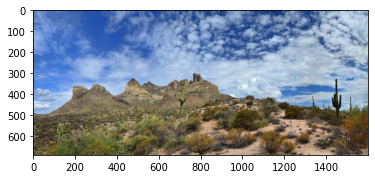

In [67]:
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB));

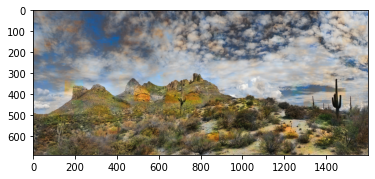

In [68]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)); # 45번 학습 반복

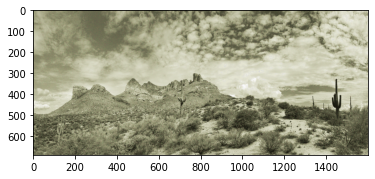

In [69]:
plt.imshow(cv2.cvtColor(test_image_faded, cv2.COLOR_BGR2RGB));

In [60]:
test_image = tf.squeeze(tf.cast(test_image, dtype=np.uint8), axis=0)
print(test_image.shape)

(1044, 1600, 3)


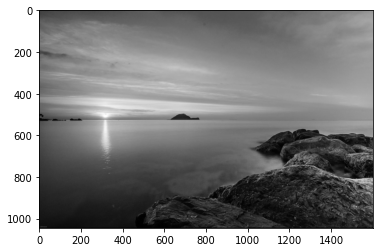

In [63]:
plt.imshow(cv2.cvtColor(np.array(test_image), cv2.COLOR_BGR2RGB));